<a href="https://colab.research.google.com/github/labadilloj/TLG-DS-2025/blob/main/DS_C3_SC2_LeslieBadillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Reto: Análisis para abrir una sucursal de comida rápida en México

1. Crea una nueva libreta de Google Colab para programar tu script en Python.

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()  # seleccionar archivo .csv y mexican-states

Saving mexican-states.cpg to mexican-states.cpg
Saving mexican-states.dbf to mexican-states.dbf
Saving mexican-states.prj to mexican-states.prj
Saving mexican-states.qpj to mexican-states.qpj
Saving mexican-states.shp to mexican-states.shp
Saving mexican-states.shx to mexican-states.shx
Saving tiendaCostco.csv to tiendaCostco.csv


2. Carga los datos de los Estados de la República Mexicana en un GeoDataFrame.

In [ ]:
estados = gpd.read_file("mexican-states.shp")
#estados.plot()

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: mexican-states.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


3. Carga los datos de la localización de las sucursales de Costco® en un DataFrame.


In [ ]:
df = pd.read_csv("tiendaCostco.csv")
#print(df.head)
print(df.columns)
df.columns = df.columns.str.strip()


Index(['id', ' nombre', ' direccion', ' ubicacion', ' latitud', ' longitud',
       ' tel centro llantero'],
      dtype='object')


4. Convierte los datos de la localización de las sucursales de Costco® en un GeoDataFrame, creando puntos a partir de la longitud y latitud de cada sucursal.

In [ ]:
costco_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitud"], df["latitud"]),
    crs="EPSG:4326"  # ¡IMPORTANTE!
)


5. Agrega una columna a los estados que indique la región a la que pertenecen y separa el GeoDataFrame por regiones en lugar de por estados.

In [ ]:
from unidecode import unidecode

def norm(s: str) -> str:
    s = unidecode(str(s)).strip().lower()
    s = " ".join(s.split())
    s = s.replace("Coahuila de Zaragoza", "Coahuila")
    s = s.replace("Michoacan de Ocampo", "Michoacan")
    s = s.replace("Veracruz de Ignacio de la Llave", "Veracruz")
    return s

estados["name_norm"] = estados["name"].apply(norm)

regiones_list = {
    "Centro": ["Ciudad de México","México","Hidalgo","Morelos","Puebla","Tlaxcala"],
    "Noreste": ["Coahuila de Zaragoza","Nuevo León","Tamaulipas"],
    "Noroeste": ["Baja California","Baja California Sur","Sonora","Sinaloa","Chihuahua", "Durango"],
    "Centro-occidente": ["Jalisco","Colima","Michoacán de Ocampo","Nayarit","Aguascalientes","Guanajuato","Querétaro","Zacatecas", "San Luis Potosí"],
    "Sureste": ["Veracruz de Ignacio de la Llave","Tabasco","Campeche","Yucatán","Quintana Roo","Oaxaca","Chiapas","Guerrero"]
}

estado_a_region_norm = {
    norm(edo): reg
    for reg, lista in regiones_list.items()
    for edo in lista
}

estados["region"] = estados["name_norm"].map(estado_a_region_norm)


6. Asegura que ambos GeoDataFrames utilicen el CRS epsg=3395 que usa metros como medida de distancia.

In [ ]:
estados = estados.to_crs(epsg=3395)
costco_gdf = costco_gdf.to_crs(epsg=3395)

print("CRS estados:", estados.crs)
print("CRS puntos :", costco_gdf.crs)

CRS estados: EPSG:3395
CRS puntos : EPSG:3395


7. Crea un buffer de 120 km alrededor de los puntos de localización de cada sucursal.

In [ ]:
costco_buffer = costco_gdf.copy()
costco_buffer["geometry"] = costco_buffer.buffer(120000)

8. Grafica la intersección de las regiones con los círculos creados a partir de la localización de las sucursales.

In [ ]:
localizacion = gpd.overlay(estados, costco_buffer, how="intersection", keep_geom_type=False)

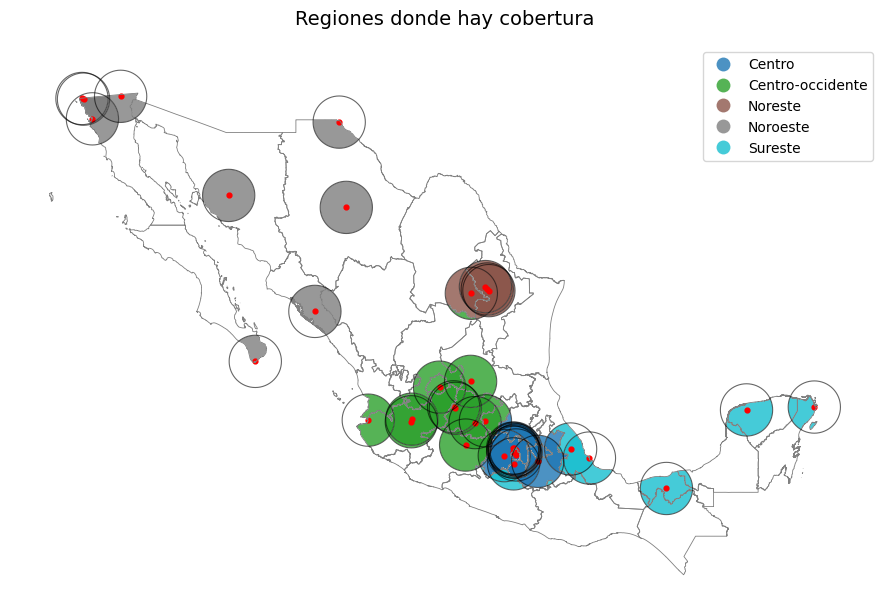

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
localizacion.plot(ax=ax, column="region", alpha=0.8,
                  edgecolor="white", linewidth=0.4, legend=True)
estados.boundary.plot(ax=ax, color="gray", linewidth=0.6)
costco_buffer.boundary.plot(ax=ax, color="black", linewidth=0.8, alpha=0.6)
costco_gdf.plot(ax=ax, color="red", markersize=12)
ax.set_title("Regiones donde hay cobertura", fontsize=14, pad=15)

ax.set_axis_off()
plt.tight_layout(); plt.show()

9.Identifica las regiones en donde se requiere más cobertura e indica en qué regiones del país NO es conveniente abrir una nueva sucursal debido a la falta de cobertura de entregas a domicilio.

In [ ]:
localizacion_2 = gpd.overlay(estados, costco_buffer, how="difference", keep_geom_type=False)

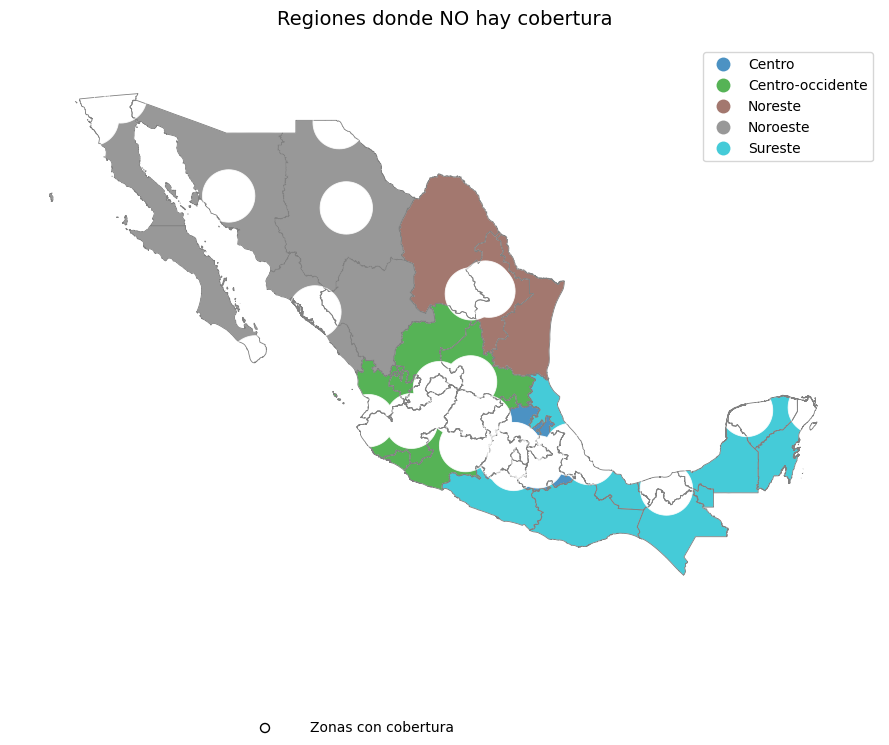

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
leg1 = localizacion_2.plot(ax=ax, column="region", alpha=0.8,
                  edgecolor="white", linewidth=0.4, legend=True)
estados.boundary.plot(ax=ax, color="gray", linewidth=0.6)
costco_buffer.boundary.plot(ax=ax, color="white", linewidth=0.8, alpha=0.6)

ax.set_title("Regiones donde NO hay cobertura", fontsize=14, pad=15)

circle = mpatches.Circle((0.3, 0.05), 0.005, facecolor="white", edgecolor="black", transform=fig.transFigure)
fig.patches.append(circle)
fig.text(0.35, 0.05, "Zonas con cobertura", fontsize=10, va="center")
ax.set_axis_off()
plt.tight_layout()
plt.show()